In [1]:
import torch
import torch.nn as nn
from torch.nn.utils import weight_norm
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset #IterableDataset
import sys
import os
from tqdm import tqdm

import sys
import os

os.chdir(os.path.abspath(''))
sys.path.append(os.path.abspath(os.path.abspath('')))
sys.path.append(os.path.abspath(os.path.abspath('') + '/src'))

from utils import *
from models import *

import pandas as pd
import numpy as np

In [2]:
df_train_total = pd.read_csv("../data/df_train_total.csv")
df_test_total = pd.read_csv("../data/df_test_total.csv")
df_merged = pd.read_csv("../data/df_merged.csv")

In [3]:
def generate_ts_data(df, label_df, input_seq_len=48, tau=12):
    conti_input_list = []
    cate_input_list = []
    future_input_list = []
    label_list = []
    col_labels =  ['wl_1018680'] # ['wl_1018662', 'wl_1018680', 'wl_1018683', 'wl_1019630']
    
    for i in df['year'].unique():
        tmp_df = np.array(df.loc[df['year'] == i, :])
        tmp_label_df = np.array(label_df.loc[label_df['year'] == i, col_labels])
        n = tmp_df.shape[0] - input_seq_len - tau 
        
        tmp_conti_input = tmp_df[:, 4:] # (4416, 16)
        tmp_cate_input = tmp_df[:, 1:4] # (4416, 3)
        
        conti_input = np.zeros((n, input_seq_len, tmp_conti_input.shape[1]), dtype=np.float32)
        cate_input = np.zeros((n, input_seq_len, tmp_cate_input.shape[1]), dtype=np.float32)
        future_input = np.zeros((n, tau, tmp_cate_input.shape[1]), dtype=np.float32)
        label = np.zeros((n, tau, len(col_labels)))
    
        for j in range(n):
            conti_input[j, :, :] = tmp_conti_input[j:(j+input_seq_len), :]
            cate_input[j, :, :] = tmp_cate_input[j:(j+input_seq_len), :]
            future_input[j, :, :] = tmp_cate_input[(j+input_seq_len):(j+input_seq_len+tau), :]
            label[j, :, :] = tmp_label_df[(j+input_seq_len):(j+input_seq_len+tau), :]/1000

        conti_input_list.append(conti_input)
        cate_input_list.append(cate_input)
        future_input_list.append(future_input)
        label_list.append(label)
    
    total_conti_input = np.concatenate(conti_input_list, axis=0)
    total_cate_input = np.concatenate(cate_input_list, axis=0)
    total_future_input = np.concatenate(future_input_list, axis=0)
    total_label = np.concatenate(label_list, axis=0)
    
    return total_conti_input, total_cate_input, total_future_input, total_label

In [4]:
def generate_eval_ts(df, label_df, input_seq_len=48, tau=12):    
    col_labels =  ['wl_1018680'] # ['wl_1018662', 'wl_1018680', 'wl_1018683', 'wl_1019630']
    
    tmp_df = np.array(df.loc[df['year'] == 2021, :])
    tmp_label_df = np.array(label_df.loc[label_df['year'] == 2021, col_labels])
    
    n = tmp_df.shape[0] - input_seq_len - tau 
    
    tmp_conti_input = tmp_df[:, 4:] # (4416, 16)
    conti_input = np.zeros((n, input_seq_len, tmp_conti_input.shape[1]), dtype=np.float32)
    label = np.zeros((n, tau, len(col_labels)))

    past_input = np.zeros((n, input_seq_len, len(col_labels)), dtype=np.float32)
    label = np.zeros((n, tau, len(col_labels)))

    for j in range(n):
        past_input[j, :, :] = tmp_label_df[j:(j+input_seq_len), :]/1000
        conti_input[j, :, :] = tmp_conti_input[j:(j+input_seq_len), :]
        label[j, :, :] = tmp_label_df[(j+input_seq_len):(j+input_seq_len+tau), :]/1000

    return conti_input, label, past_input

In [5]:
ding = STALSTM(48, 16, 12, 5)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
ding.to(device)
optimizer = optim.Adam(ding.parameters(), lr=0.001)

In [6]:
class QuantileRisk(nn.Module):
    def __init__(self, tau, quantile, num_targets, device):
        super(QuantileRisk, self).__init__()
        self.quantile = quantile
        self.device = device
        self.q_arr = torch.tensor(self.quantile).float().unsqueeze(0).unsqueeze(-1).repeat(1, 1, tau).unsqueeze(1).repeat(1, num_targets, 1, 1).to(self.device)
    
    def forward(self, true, pred):
        true_rep = true.unsqueeze(-1).repeat(1, 1, 1, len(self.quantile)).permute(0, 2, 3, 1).to(self.device)
        pred = pred.permute(0, 2, 3, 1)

        ql = torch.maximum(self.q_arr * (true_rep - pred), (1-self.q_arr)*(pred - true_rep))
        
        return ql.mean()

def train(model, loader, criterion, optimizer, device):
    
    model.train()
    
    total_loss = []
    
    for batch in loader:
        conti_input, true_y = batch 
        
        conti_input = conti_input.to(device)
        true_y = true_y.to(device)
        
        pred, _, _ = model(conti_input)
        
        loss = criterion(true_y, pred)
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
        
        total_loss.append(loss)
        
    return sum(total_loss)/len(total_loss)

criterion = QuantileRisk(12, [0.1, 0.3, 0.5, 0.7, 0.9], 1, device)

In [7]:
train_conti_input, _, _, train_label = generate_ts_data(df_train_total, df_merged)
train_dataset = TensorDataset(torch.FloatTensor(train_conti_input), torch.FloatTensor(train_label))
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=512)

In [8]:
pbar = tqdm(range(100))

for epoch in pbar:        
    train_loss = train(ding, train_loader, criterion, optimizer, device)
    pbar.set_description("Train Loss: {:.4f}".format(train_loss))
    
torch.save(ding.state_dict(), './assets/weights/ding.pth')

Train Loss: 0.0800:   1%|          | 1/100 [00:02<04:21,  2.64s/it]


KeyboardInterrupt: 

In [9]:
ding.load_state_dict(torch.load('../assets/STALSTM.pth', map_location='cpu'))

<All keys matched successfully>

In [10]:
ding.eval()
test_input, eval_label, past_input = generate_eval_ts(df_test_total, df_merged)

eval_label = torch.tensor(eval_label)
ding_output, alpha, beta = ding(torch.tensor(test_input))

torch.maximum(0.9 * (eval_label.squeeze() - ding_output[..., 4].squeeze()), (1-0.9)*(ding_output[..., 4].squeeze() -eval_label.squeeze() )).mean() # 0.0030
torch.maximum(0.7 * (eval_label.squeeze() - ding_output[..., 3].squeeze()), (1-0.7)*(ding_output[..., 3].squeeze() -eval_label.squeeze() )).mean() # 0.0051
torch.maximum(0.5 * (eval_label.squeeze() - ding_output[..., 2].squeeze()), (1-0.5)*(ding_output[..., 2].squeeze() -eval_label.squeeze() )).mean() # 0.0053

np.mean(eval_label.squeeze().cpu().numpy() < ding_output[..., 4].squeeze().detach().cpu().numpy())
0.9 - np.mean(eval_label.squeeze().cpu().numpy() < ding_output[..., 4].squeeze().detach().cpu().numpy())

np.mean(eval_label.squeeze().cpu().numpy() < ding_output[..., 3].squeeze().detach().cpu().numpy())
0.7 - np.mean(eval_label.squeeze().cpu().numpy() < ding_output[..., 3].squeeze().detach().cpu().numpy())

np.mean(eval_label.squeeze().cpu().numpy() < ding_output[..., 2].squeeze().detach().cpu().numpy())
0.5 - np.mean(eval_label.squeeze().cpu().numpy() < ding_output[..., 2].squeeze().detach().cpu().numpy())

-0.04746326905417819

([], [])

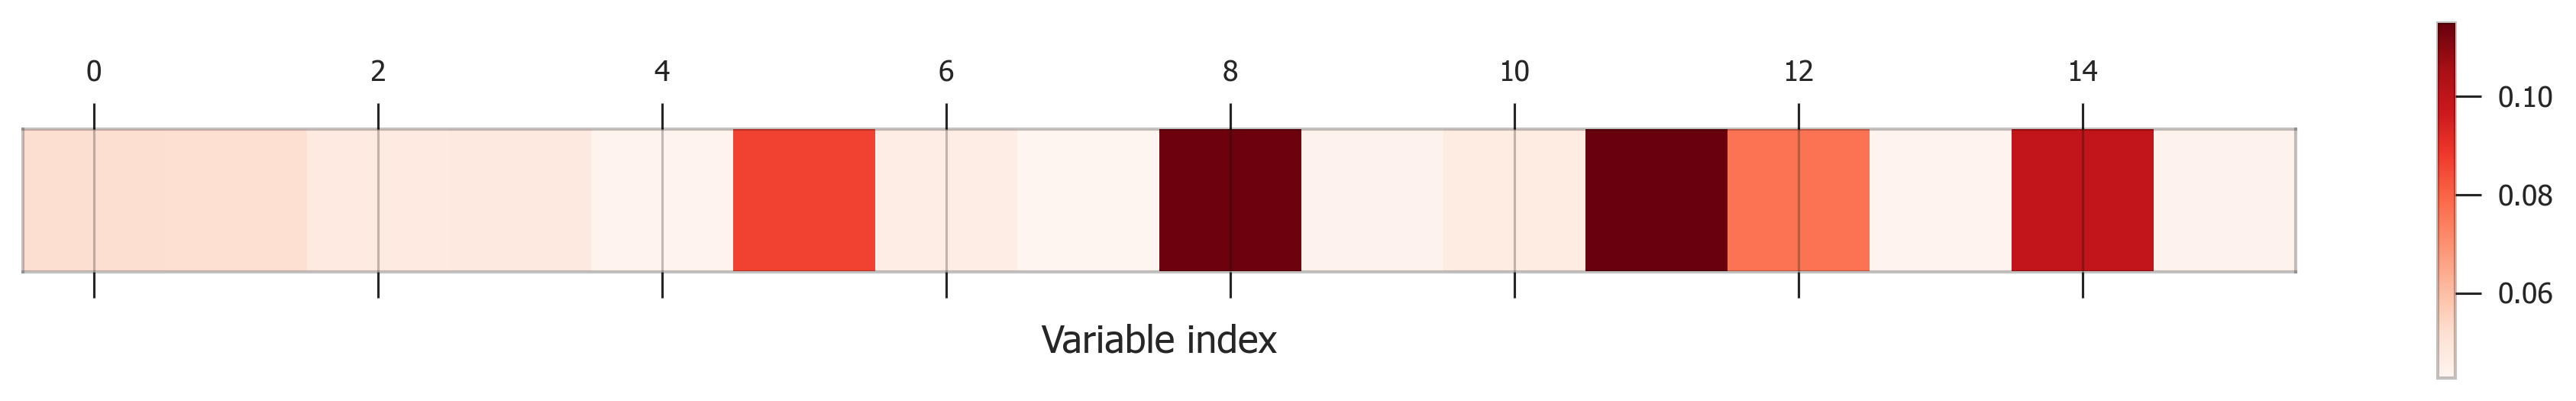

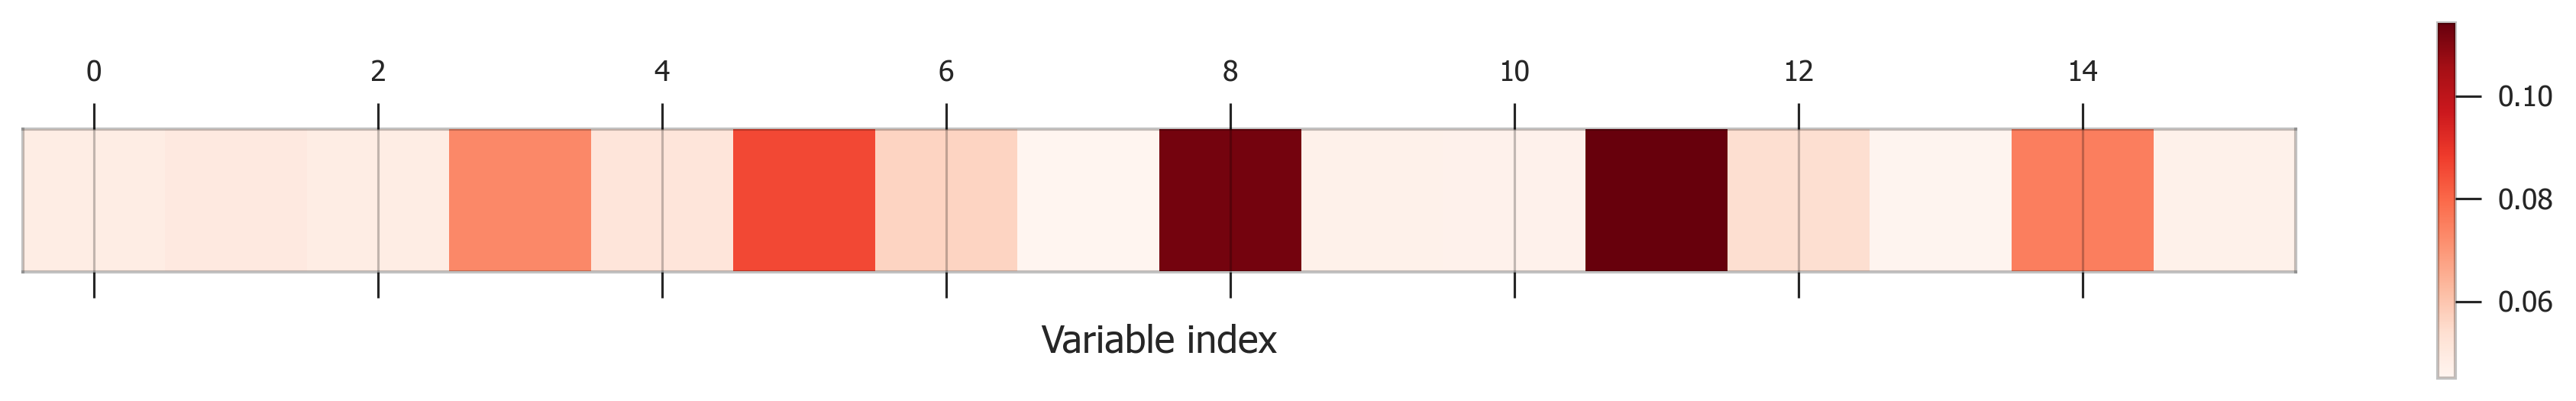

In [11]:
import seaborn as sns
from ing_theme_matplotlib import mpl_style # pip install ing_theme_matplotlib 
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams["figure.dpi"] = 300
mpl_style(dark=False)

# Rainy
batch_num = 1549
plt.matshow(alpha[batch_num, 1:2, :].detach().numpy(), cmap='Reds')
plt.colorbar()
plt.xlabel("Variable index")
plt.yticks([])

# Dry
batch_num = 60
plt.matshow(alpha[batch_num, 0:1, ...].detach().numpy(), cmap='Reds')
plt.colorbar()
plt.xlabel("Variable index")
plt.yticks([])